# chapter10 モデルの検証方法とチューニング方法

In [2]:
import numpy as np
import numpy.random as radom
import scipy as sp
from pandas import Series,DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
sns.set()
import sklearn
%precision 3

'%.3f'

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
cancer = load_breast_cancer()
tree = DecisionTreeClassifier(criterion='entropy',max_depth=3,random_state=0)
scores = cross_val_score(tree,cancer.data,cancer.target,cv=5)
print('Cross validation scores: {}'.format(scores))
print('Cross validation scores: {:.3f}+-{:.3f}'.format(scores.mean(),scores.std()))

Cross validation scores: [0.904 0.912 0.956 0.939 0.956]
Cross validation scores: 0.933+-0.022


ベストスコア:0.91
その時のパラメータ(gamma,C)：(0.001, 1.0)


<AxesSubplot:>

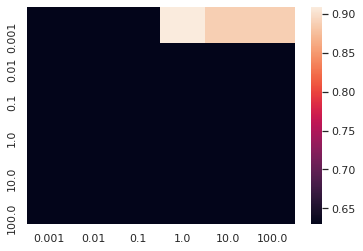

In [4]:
# 例）サポートベクターマシンのグリッドサーチ
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
X_train,X_test,y_train,y_test = train_test_split(cancer.data,cancer.target,stratify=cancer.target,random_state=0)

# ハイパーパラメータのすべての組み合わせでモデルを構築・検証
scores = {}
for gamma in np.logspace(-3,2,num=6):
    for C in np.logspace(-3,2,num=6):
        svm = SVC(gamma=gamma,C=C)
        svm.fit(X_train,y_train)
        scores[(gamma,C)] = svm.score(X_test,y_test)
scores = pd.Series(scores)

print('ベストスコア:{:.2f}'.format(scores.max()))
print('その時のパラメータ(gamma,C)：{}'.format(scores.idxmax()))

sns.heatmap(scores.unstack())

In [5]:
# モジュールを使ったグリッドサーチ
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
cancer = load_breast_cancer()
X_train,X_test,y_train,y_test = train_test_split(cancer.data,cancer.target,stratify=cancer.target,random_state=0)
param_grid = {'C':np.logspace(-3,2,num=6)
             ,'gamma':np.logspace(-3,2,num=6)}
gs = GridSearchCV(estimator=SVC(),param_grid=param_grid,cv=5)
gs.fit(X_train,y_train)
print('Best cross validation score: {:.3f}'.format(gs.best_score_))
print('Best parameters :{}'.format(gs.best_params_))
print('Test score:{:.3f}'.format(gs.score(X_test,y_test)))

Best cross validation score: 0.925
Best parameters :{'C': 1.0, 'gamma': 0.001}
Test score:0.909


In [7]:
# モデルの評価指標
from sklearn.svm import SVC
cancer = load_breast_cancer()
X_train,X_test,y_train,y_test = train_test_split(cancer.data,cancer.target,stratify = cancer.target,random_state=66)
model=SVC(gamma=0.001,C=1)
model.fit(X_train,y_train)
print('{} train score: {:.3f}'.format(model.__class__.__name__,model.score(X_train,y_train)))
print('{} test score: {:.3f}'.format(model.__class__.__name__,model.score(X_test,y_test)))

SVC train score: 0.979
SVC test score: 0.909


In [8]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
m = confusion_matrix(y_test,y_pred)
print('Confusion matrix:\n{}'.format(m))

Confusion matrix:
[[48  5]
 [ 8 82]]


In [9]:
accuracy = (m[0,0]+m[1,1])/m.sum()
print('正解率：{:.3f}'.format(accuracy))

正解率：0.909


In [10]:
precision = (m[1,1]/m[:,1].sum())
recall = (m[1,1]/m[1,:].sum())
f1 = 2 * (precision * recall)/(precision + recall)
print('適合率：{:.3f}'.format(precision))
print('再現率：{:.3f}'.format(recall))
print('F1値：{:.3f}'.format(f1))

適合率：0.943
再現率：0.911
F1値：0.927


In [12]:
# sklearnの関数で上記の指標が求められる
from sklearn.metrics import precision_score, recall_score, f1_score
print('適合率：{:.3f}'.format(precision_score(y_test,y_pred)))
print('再現率：{:.3f}'.format(recall_score(y_test,y_pred)))
print('F1値：{:.3f}'.format(f1_score(y_test,y_pred)))

適合率：0.943
再現率：0.911
F1値：0.927


### ROC曲線

In [13]:
from sklearn.linear_model import LogisticRegression
cancer = load_breast_cancer()
X_train,X_test,y_train,y_test = train_test_split(cancer.data,cancer.target,stratify = cancer.target,random_state=66)
model = LogisticRegression(random_state=0)
model.fit(X_train,y_train)
results = pd.DataFrame(model.predict_proba(X_test),columns=cancer.target_names)
results.head()

/home/komiyama/Anaconda/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,malignant,benign
0,0.004505,0.995495
1,0.000453,0.999547
2,0.038853,0.961147
3,0.007353,0.992647
4,0.003116,0.996884


In [14]:
results.head()

,malignant,benign
0,0.004505,0.995495
1,0.000453,0.999547
2,0.038853,0.961147
3,0.007353,0.992647
4,0.003116,0.996884


In [15]:
# threshold
for threshold in [0.4,0.3,0.15,0.05]:
    results[f'flag_{threshold}'] = results['benign'].map(lambda x: 1 if x > threshold else 0)
    
results.head(10)

,malignant,benign,flag_0.4,flag_0.3,flag_0.15,flag_0.05
0,0.004505,0.995495,1,1,1,1
1,0.000453,0.999547,1,1,1,1
2,0.038853,0.961147,1,1,1,1
3,0.007353,0.992647,1,1,1,1
4,0.003116,0.996884,1,1,1,1
5,0.006581,0.993419,1,1,1,1
6,0.008022,0.991978,1,1,1,1
7,0.003171,0.996829,1,1,1,1
8,0.862013,0.137987,0,0,0,1
9,0.841989,0.158011,0,0,1,1


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='false positive rate', ylabel='true positive rate'>

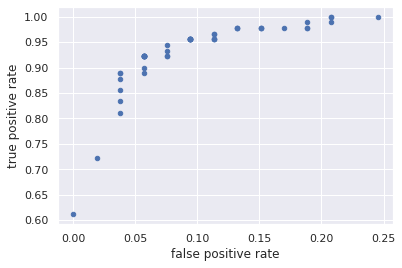

In [18]:
# ROC curve
rates = {}
for threshold in np.linspace(0.01,0.99,num=50):
    labels = results['benign'].map(lambda x: 1 if x>threshold else 0)
    m = confusion_matrix(y_test,labels)
    rates[threshold] = {'false positive rate': m[0,1]/m[0,:].sum(),
                       'true positive rate': m[1,1]/m[1,:].sum()}
pd.DataFrame(rates).T.plot.scatter('false positive rate', 'true positive rate')

In [19]:
rates

{0.01: {'false positive rate': 0.24528301886792453, 'true positive rate': 1.0},
 0.03: {'false positive rate': 0.20754716981132076, 'true positive rate': 1.0},
 0.05: {'false positive rate': 0.20754716981132076, 'true positive rate': 1.0},
 0.06999999999999999: {'false positive rate': 0.20754716981132076,
  'true positive rate': 0.9888888888888889},
 0.09: {'false positive rate': 0.18867924528301888,
  'true positive rate': 0.9888888888888889},
 0.11: {'false positive rate': 0.18867924528301888,
  'true positive rate': 0.9777777777777777},
 0.13: {'false positive rate': 0.18867924528301888,
  'true positive rate': 0.9777777777777777},
 0.15000000000000002: {'false positive rate': 0.16981132075471697,
  'true positive rate': 0.9777777777777777},
 0.17: {'false positive rate': 0.1509433962264151,
  'true positive rate': 0.9777777777777777},
 0.19: {'false positive rate': 0.1509433962264151,
  'true positive rate': 0.9777777777777777},
 0.21000000000000002: {'false positive rate': 0.15094

In [20]:
from sklearn import svm
from sklearn.metrics import roc_curve, auc
cancer = load_breast_cancer()
X_train,X_test,y_train,y_test = train_test_split(cancer.data,cancer.target,test_size=0.5,random_state=66)
model = svm.SVC(kernel='linear',probability=True,random_state=0)
model.fit(X_train,y_train)
y_pred = model.predict_proba(X_test)[:,1]

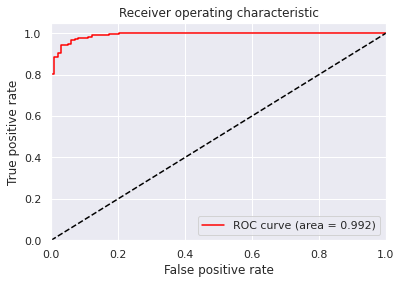

In [22]:
# 　偽陽性率と真陽性率の算出
fpr,tpr,thresholds = roc_curve(y_test,y_pred)
auc = auc(fpr,tpr)

plt.plot(fpr,tpr,color='red',label='ROC curve (area = %.3f)' % auc)
plt.plot([0,1],[0,1],color='black',linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="best")

In [23]:
from sklearn.datasets import load_boston
boston = load_boston()
X = pd.DataFrame(boston.data, columns = boston.feature_names)
y = pd.Series(boston.target,name='MEDV')
X.join(y).head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [26]:
# 重回帰、リッジ回帰、決定木、線形サポートベクター回帰
# MAE,MSE,MedAE,R2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,random_state=0)

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

models = {
    'LinearRegression':LinearRegression(),
    'Ridge':Ridge(random_state=0),
    'DecisionTreeRegressor':DecisionTreeRegressor(random_state=0),
    'LinearSVR':LinearSVR(random_state=0)
}

scores = {}
for model_name, model in models.items():
    model.fit(X_train,y_train)
    scores[(model_name, 'MSE')] = mean_squared_error(y_test,model.predict(X_test))
    scores[(model_name, 'MAE')] = mean_absolute_error(y_test,model.predict(X_test))
    scores[(model_name, 'MedAE')] = median_absolute_error(y_test,model.predict(X_test))
    scores[(model_name, 'R2')] = r2_score(y_test,model.predict(X_test))
pd.Series(scores).unstack()

,MAE,MSE,MedAE,R2
DecisionTreeRegressor,3.064822,24.590435,1.900000,0.675653
LinearRegression,3.627793,25.301662,2.903830,0.666272
LinearSVR,3.275385,26.799616,2.092362,0.646514
Ridge,3.618201,25.282890,2.930524,0.666520


### アンサンブル学習

In [29]:
# バギング
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
X_train,X_test,y_train,y_test = train_test_split(cancer.data,cancer.target,stratify=cancer.target,random_state=66)
models = {
    'kNN': KNeighborsClassifier(),
    'bagging': BaggingClassifier(KNeighborsClassifier(),n_estimators = 100,random_state=0)
}

scores = {}
for model_name, model in models.items():
    model.fit(X_train,y_train)
    scores[(model_name,'train_score')] = model.score(X_train,y_train)
    scores[(model_name,'test_score')] = model.score(X_test,y_test)

pd.Series(scores).unstack()

,test_score,train_score
bagging,0.937063,0.950704
kNN,0.923077,0.948357


In [30]:
pd.Series(scores)

kNN      train_score    0.948357
         test_score     0.923077
bagging  train_score    0.950704
         test_score     0.937063
dtype: float64

In [32]:
scores

{('kNN', 'train_score'): 0.9483568075117371,
 ('kNN', 'test_score'): 0.9230769230769231,
 ('bagging', 'train_score'): 0.9507042253521126,
 ('bagging', 'test_score'): 0.9370629370629371}

In [34]:
# ブースティング
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
boston = load_boston()
X_train,X_test,y_train,y_test = train_test_split(boston.data,boston.target,random_state=66)
models = {
    'tree':DecisionTreeRegressor(random_state=0),
    'AdaBoost':AdaBoostRegressor(DecisionTreeRegressor(),random_state=0)
}
scores = {}
for model_name, model in models.items():
    model.fit(X_train,y_train)
    scores[(model_name,'train_score')] = model.score(X_train,y_train)
    scores[(model_name,'test_score')] = model.score(X_test,y_test)
pd.Series(scores).unstack()

,test_score,train_score
AdaBoost,0.922829,0.999522
tree,0.721430,1.000000


### ランダムフォレスト、勾配ブースティング

In [35]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
boston = load_boston()
X_train,X_test,y_train,y_test = train_test_split(boston.data,boston.target,random_state=66)
models = {
    'RandomForest': RandomForestRegressor(random_state=0),
    'GradientBoost': GradientBoostingRegressor(random_state=0)
}
scores = {}
for model_name, model in models.items():
    model.fit(X_train,y_train)
    scores[(model_name,'train_score')] = model.score(X_train,y_train)
    scores[(model_name,'test_score')] = model.score(X_test,y_test)
    
pd.Series(scores).unstack()

,test_score,train_score
GradientBoost,0.926076,0.977138
RandomForest,0.894637,0.979374


<AxesSubplot:>

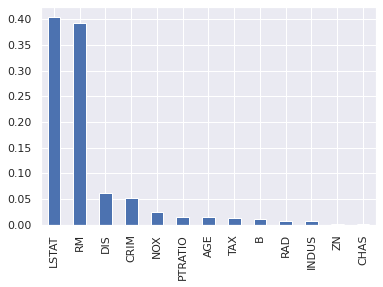

In [38]:
# 変数の重要度
s = pd.Series(models['RandomForest'].feature_importances_,
             index=boston.feature_names)
s.sort_values(ascending=False).plot.bar(color='C0')